<a href="https://colab.research.google.com/github/satyashree806/Sentiment_Analysis_Internship/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install any extra packages
!pip install imbalanced-learn --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Upload your Amazon Musical Instruments review dataset to Colab first
# (click the folder icon at left → Upload file)

# Replace with your uploaded file name:
df = pd.read_csv('/content/Musical_instruments_reviews.csv')

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (10261, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"



Missing values per column:
reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64


/tmp/ipython-input-500058554.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='pastel')


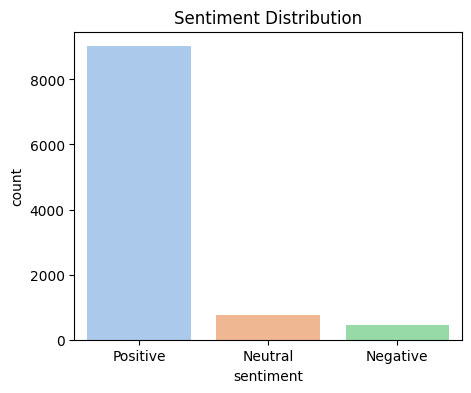

,reviewText,overall,sentiment
0,"Not much to write about here, but it does exac...",5.0,Positive
1,The product does exactly as it should and is q...,5.0,Positive
2,The primary job of this device is to block the...,5.0,Positive
3,Nice windscreen protects my MXL mic and preven...,5.0,Positive
4,This pop filter is great. It looks and perform...,5.0,Positive


In [ ]:
# Check null values
print("\nMissing values per column:")
print(df.isnull().sum())

# Drop rows where reviewText or overall rating is missing
df = df.dropna(subset=['reviewText', 'overall'])

# Create sentiment labels from 'overall' rating
def label_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['overall'].apply(label_sentiment)

# Plot distribution of sentiments
plt.figure(figsize=(5,4))
sns.countplot(x='sentiment', data=df, palette='pastel')
plt.title('Sentiment Distribution')
plt.show()

df[['reviewText','overall','sentiment']].head()


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove non-letter characters
    text = re.sub('[^a-zA-Z]', ' ', str(text))
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df['clean_review'] = df['reviewText'].apply(clean_text)
df[['reviewText','clean_review']].head()


,reviewText,clean_review
0,"Not much to write about here, but it does exac...",much write exactly supposed filter pop sound r...
1,The product does exactly as it should and is q...,product exactly quite affordable realized doub...
2,The primary job of this device is to block the...,primary job device block breath would otherwis...
3,Nice windscreen protects my MXL mic and preven...,nice windscreen protects mxl mic prevents pop ...
4,This pop filter is great. It looks and perform...,pop filter great look performs like studio fil...


In [ ]:
X = df['clean_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 8203
Testing samples: 2051


In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [ ]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_tfidf, y_train)
print("Balanced training samples:", X_train_bal.shape[0])


Balanced training samples: 21636


In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_bal, y_train_bal)


LogisticRegression(max_iter=1000)


Classification Report:
              precision    recall  f1-score   support

    Negative       0.32      0.49      0.39        93
     Neutral       0.26      0.39      0.31       155
    Positive       0.94      0.87      0.90      1803

    accuracy                           0.82      2051
   macro avg       0.51      0.59      0.53      2051
weighted avg       0.86      0.82      0.83      2051



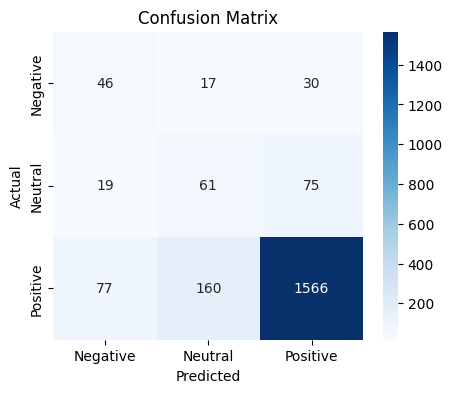

In [ ]:
y_pred = model.predict(X_test_tfidf)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
new_reviews = [
    "This instrument is amazing and very durable!",
    "Poor quality and broke after one use."
]

clean_new = [clean_text(r) for r in new_reviews]
tfidf_new = tfidf.transform(clean_new)
predictions = model.predict(tfidf_new)

for review, pred in zip(new_reviews, predictions):
    print(f"Review: {review}\nPredicted Sentiment: {pred}\n")


Review: This instrument is amazing and very durable!
Predicted Sentiment: Positive

Review: Poor quality and broke after one use.
Predicted Sentiment: Negative

